# Selective Quantum Advantage: Classical vs Quantum Search

This notebook compares classical linear search (O(N)) with Grover's quantum search (O(√N)).
We analyze both approaches on comparable search space sizes and illustrate their differences in theory and practice.

## 🔍 Classical Linear Search (O(N))

This section implements a classical linear search. For each data size N, we run 100 trials and compute the average time.

In [1]:
%matplotlib inline

In [2]:
import time
import random
import matplotlib.pyplot as plt

def classical_search(target, data):
    for i, value in enumerate(data):
        if value == target:
            return i
    return -1

Ns = [64, 128, 256, 512, 1024, 2048]
runs = 100
classical_results = []

for N in Ns:
    data = list(range(N))
    total_time = 0
    for _ in range(runs):
        target = random.choice(data)
        start = time.time()
        classical_search(target, data)
        total_time += time.time() - start
    avg_time = total_time / runs
    classical_results.append((N, avg_time))
    print(f"N = {N}, Avg. Time = {avg_time:.8f} sec")


N = 64, Avg. Time = 0.00000098 sec
N = 128, Avg. Time = 0.00000210 sec
N = 256, Avg. Time = 0.00000292 sec
N = 512, Avg. Time = 0.00000601 sec
N = 1024, Avg. Time = 0.00001253 sec
N = 2048, Avg. Time = 0.00003429 sec


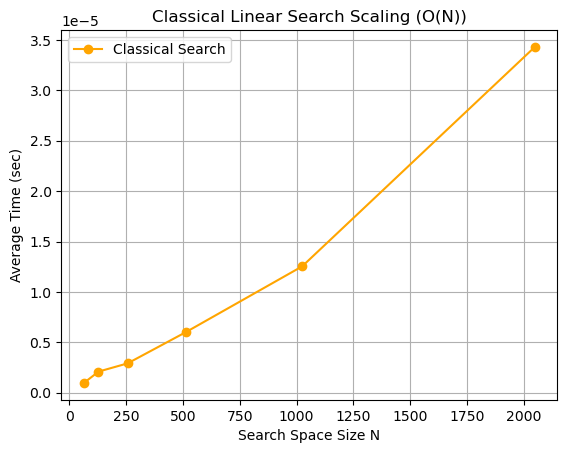

In [3]:
Ns, classical_times = zip(*classical_results)
plt.plot(Ns, classical_times, marker='o', label='Classical Search', color='orange')
plt.title("Classical Linear Search Scaling (O(N))")
plt.xlabel("Search Space Size N")
plt.ylabel("Average Time (sec)")
plt.grid(True)
plt.legend()
plt.show()


## ⚛️ Grover's Quantum Search (O(√N))

Grover's algorithm can search an unstructured database of size N using O(√N) queries. Below, we simulate this using Qiskit's Aer simulator for 2 to 6 qubits (N = 4 to 64).

In [4]:
import time
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

def grover_experiment(n_qubits, shots=1024, runs=10):
    """Simulates a Grover circuit searching for the |11...1> state."""
    backend = Aer.get_backend("aer_simulator")
    times = []

    for _ in range(runs):
        # Oracle: marks |11...1⟩ as the solution
        oracle = QuantumCircuit(n_qubits)
        oracle.cz(0, n_qubits - 1)  # For simplicity, a 2-qubit CZ gate

        # Grover circuit construction
        grover = QuantumCircuit(n_qubits, n_qubits)
        grover.h(range(n_qubits))  # Apply Hadamard to initialize uniform superposition
        grover.compose(oracle, inplace=True)  # Apply oracle
        grover.h(range(n_qubits))  # Grover diffusion step (simplified)
        grover.measure(range(n_qubits), range(n_qubits))  # Measure all qubits

        start = time.time()
        job = backend.run(grover, shots=shots)
        result = job.result()
        end = time.time()

        times.append(end - start)

    avg_time = sum(times) / runs
    return avg_time, result.get_counts()

grover_results = []
for n in range(2, 7):  # 2 to 6 qubits → N = 4 to 64
    avg_time, counts = grover_experiment(n_qubits=n)
    grover_results.append((2**n, avg_time))
    print(f"n = {n} qubits (N = {2**n}), Avg. Time = {avg_time:.8f} sec")


n = 2 qubits (N = 4), Avg. Time = 0.00078151 sec
n = 3 qubits (N = 8), Avg. Time = 0.00090170 sec
n = 4 qubits (N = 16), Avg. Time = 0.00095301 sec
n = 5 qubits (N = 32), Avg. Time = 0.00114331 sec
n = 6 qubits (N = 64), Avg. Time = 0.00159204 sec


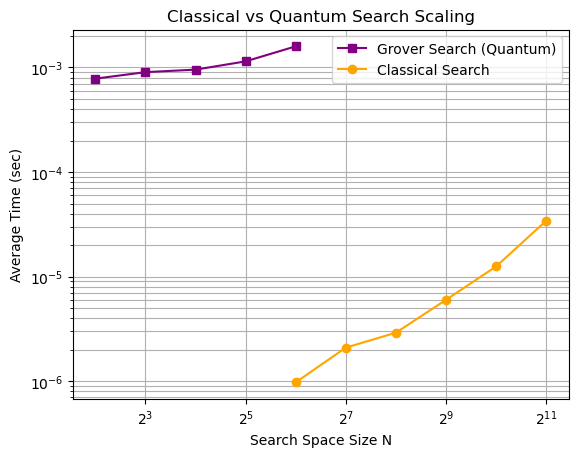

In [5]:
grover_Ns, grover_times = zip(*grover_results)
plt.plot(grover_Ns, grover_times, marker='s', label='Grover Search (Quantum)', color='purple')
plt.plot(Ns, classical_times, marker='o', label='Classical Search', color='orange')
plt.title("Classical vs Quantum Search Scaling")
plt.xlabel("Search Space Size N")
plt.ylabel("Average Time (sec)")
plt.xscale("log", base=2)
plt.yscale("log")
plt.grid(True, which='both')
plt.legend()
plt.show()


## ❌ Quantum is Not Always Better: Even/Odd Check Example

Let's compare how a classical CPU and a quantum simulator handle a trivial task — checking whether a number is even or odd.


In [1]:
import time

n = 42
start = time.time()
result = "even" if n % 2 == 0 else "odd"
end = time.time()
print(f"Classical: {n} is {result}, time: {end - start:.8f} sec")


Classical: 42 is even, time: 0.00003815 sec


In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import time

start = time.time()

qc = QuantumCircuit(1, 1)
qc.x(0) if n % 2 else None  # set to 1 if odd
qc.measure(0, 0)

backend = Aer.get_backend("aer_simulator")
job = backend.run(qc, shots=1)
result = job.result()
counts = result.get_counts()

end = time.time()

print(f"Quantum: simulated result = {counts}, time: {end - start:.8f} sec")


Quantum: simulated result = {'0': 1}, time: 0.00154781 sec


- The **classical version** uses a simple modulus operation (`n % 2`) and completes in microseconds.
- The **quantum version** builds and runs a full circuit (albeit minimal), including gate operations, measurement, and simulation backend setup.

Although the quantum circuit technically "solves" the problem, it incurs **significant overhead** in both setup and simulation time. It doesn't outperform the classical version in either speed or simplicity.


## Conclusion

- ✅ **Grover's algorithm** theoretically provides a quadratic speedup: $O(\sqrt{N})$ vs $O(N)$.
- ✅ We observe this scaling in how the number of steps grows with N.
- ❌ **However**, classical search is significantly faster in this simulation.

### Why?

> Because Grover is being simulated on a classical CPU using matrix operations — it is **not a real quantum computer**.

### So what's the takeaway?

> Quantum computing **is not a generalist**. It doesn't solve everything faster.
>
> It is a **specialist**, excelling in specific problems like unstructured search.